In [11]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "eval_framework")))

from data_loader import load_data, split_data
from reporter import BaseRecommenderReporter


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Load Data

In [14]:
def load_data_mac(sample_size=None):
    """Load MovieLens dataset"""
    print("Loading data...")
    print("Loading MovieLens 100K dataset...")
    
    # Load ratings
    ratings = pd.read_csv('../data/ml-latest-small/ml-latest-small/ratings.csv')
    
    # Load movies
    movies = pd.read_csv('../data/ml-latest-small/ml-latest-small/movies.csv')
    
    
    # Convert genres to list format
    movies['genres'] = movies['genres'].str.split('|')
    movies = movies[['movieId', 'title', 'genres']]
    
    if sample_size:
        # Sample users
        unique_users = ratings['userId'].unique()
        sampled_users = np.random.choice(unique_users, size=sample_size, replace=False)
        ratings = ratings[ratings['userId'].isin(sampled_users)]
        movies = movies[movies['movieId'].isin(ratings['movieId'].unique())]
    
    print(f"Loaded {len(ratings)} ratings and {len(movies)} movies")
    return ratings, movies

In [15]:
import os
print(os.getcwd())

/Users/angela/Desktop/probabilistic-movie-recommender/SPN


In [16]:
ratings, movies = load_data_mac()

movie_encoder = LabelEncoder()
movies["movieId"] = movie_encoder.fit_transform(movies["movieId"])
ratings["movieId"] = movie_encoder.transform(ratings["movieId"])

df = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")

# One-hot encode genres
df_expanded = df["genres"].str.get_dummies(sep="|")
df = pd.concat([df.drop(columns=["genres"]), df_expanded], axis=1)

genre_columns = df_expanded.columns.tolist()
feature_columns = ["userId", "movieId"] + genre_columns


Loading data...
Loading MovieLens 100K dataset...
Loaded 100836 ratings and 9742 movies


In [17]:
# ratings, movies = load_data_mac()

# # Encode movieId in both datasets
# movie_encoder = LabelEncoder()
# movies["movieId"] = movie_encoder.fit_transform(movies["movieId"])
# ratings["movieId"] = movie_encoder.transform(ratings["movieId"])

# # Merge genres with ratings
# df = ratings.merge(movies[["movieId", "genres"]], on="movieId", how="left")
# df_expanded = df["genres"].str.get_dummies(sep="|")
# df = pd.concat([df.drop(columns=["genres"]), df_expanded], axis=1)

# df["rating_class"] = df["rating"].astype(int)


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

In [22]:
# Dimensionality reduction on genre using PCA
genre_columns = df_expanded.columns.tolist()
scaler = StandardScaler()
pca = PCA(n_components=5)

scaled_genres = scaler.fit_transform(df[genre_columns])
pca_genres = pca.fit_transform(scaled_genres)

pca_columns = [f"pca_genre_{i}" for i in range(pca_genres.shape[1])]
df_pca = pd.DataFrame(pca_genres, columns=pca_columns)
df = pd.concat([df.drop(columns=genre_columns), df_pca], axis=1)


## Train Model

In [20]:
from spn.structure.Base import Context
from spn.structure.StatisticalTypes import MetaType
from spn.algorithms.LearningWrappers import learn_classifier
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.algorithms.LearningWrappers import learn_parametric
import scipy
scipy.NINF = float("-inf")

In [21]:
import time
from memory_profiler import memory_usage
X = df[feature_columns].values.astype(float)
y = df[["rating"]].values.astype(float)  
data = np.concatenate((X, y), axis=1)

train_data, test_data = split_data(data)
param_types = [Categorical, Categorical] + [Categorical]*len(genre_columns) + [Gaussian]
context = Context(parametric_types=param_types)
context.add_domains(train_data)

def train():
    start = time.time()
    # Learn SPN classifier
    spn = learn_classifier(train_data, context, spn_learn_wrapper=learn_parametric, label_idx=train_data.shape[1]-1)
    end = time.time()
    return spn, end - start

mem_usage, (spn, runtime) = memory_usage(train, retval=True, max_iterations=1)
print(f"Runtime: {runtime:.4f} seconds")
print(f"Memory peak: {max(mem_usage) - min(mem_usage):.2f} MiB")



\nSplitting data...
Training set size: 80668, Test set size: 20168


Process SpawnPoolWorker-47:
Process SpawnPoolWorker-43:
Process MemTimer-49:
Process SpawnPoolWorker-41:
Process SpawnPoolWorker-45:
Process SpawnPoolWorker-33:
Process SpawnPoolWorker-36:
Process SpawnPoolWorker-39:
Process SpawnPoolWorker-37:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/angela/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/angela/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/angela/anaconda3/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/angela/anaconda3/lib/python3.11/multiprocessing/queues.py", line 364, in get
  

KeyboardInterrupt: 

In [23]:

feature_columns = ["userId", "movieId"] + pca_columns
X = df[feature_columns].values.astype(float)
y = df[["rating"]].values.astype(float)
data = np.concatenate([X, y], axis=1)
train_data, test_data = split_data(data)

# Define SPN context
param_types = [Categorical, Categorical] + [Gaussian]*len(pca_columns) + [Gaussian]
context = Context(parametric_types=param_types)
context.add_domains(train_data)


def train():
    start = time.time()
    # Learn SPN classifier
    spn = learn_classifier(train_data, context, spn_learn_wrapper=learn_parametric, label_idx=train_data.shape[1]-1)
    end = time.time()
    return spn, end - start

mem_usage, (spn, runtime) = memory_usage(train, retval=True, max_iterations=1)
print(f"Runtime: {runtime:.4f} seconds")
print(f"Memory peak: {max(mem_usage) - min(mem_usage):.2f} MiB")


\nSplitting data...
Training set size: 80668, Test set size: 20168
Runtime: 212.4936 seconds
Memory peak: 3363.08 MiB


Inference time (ms/user): 3.8340 ms

===== SPN Classification Report =====
              precision    recall  f1-score   support

           0       0.04      0.12      0.06       289
           1       0.16      0.07      0.10       948
           2       0.25      0.14      0.18      2613
           3       0.41      0.44      0.42      6627
           4       0.43      0.57      0.49      7043
           5       0.29      0.10      0.15      2648

    accuracy                           0.38     20168
   macro avg       0.26      0.24      0.23     20168
weighted avg       0.36      0.38      0.36     20168

Accuracy: 0.3802


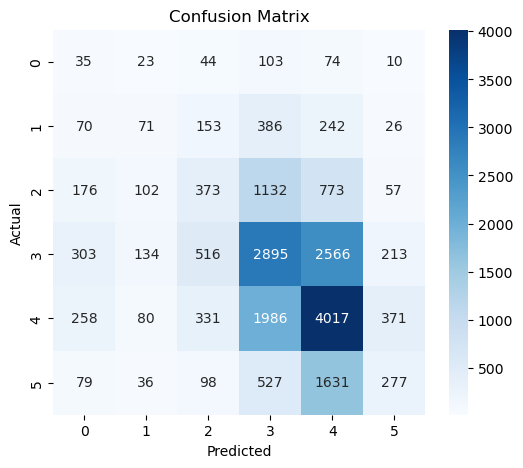

In [28]:
from spn.algorithms.MPE import mpe
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

start = time.time()
mpe_input = test_data.copy()
mpe_input[:, -1] = np.nan
predictions = mpe(spn, mpe_input)
end = time.time()
total_time = end - start  
num_users = len(np.unique(test_data[:, 0]))
print(f"Inference time (ms/user): {total_time / num_users * 1000:.4f} ms")

y_pred = predictions[:, -1].astype(int)
y_true = test_data[:, -1].astype(int)

print("\n===== SPN Classification Report =====")
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
from spn.algorithms.MPE import mpe
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


mpe_input = data.copy()
mpe_input[:, -1] = np.nan
predictions = mpe(spn, mpe_input)
y_pred = predictions[:, -1]
y_true = y.flatten()

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print("===== SPN Regression Report =====")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")


===== SPN Regression Report =====
MSE:  1.1463
RMSE: 1.0706
MAE:  0.7277


In [26]:

import numpy as np

class SPNRecommender:
    def __init__(self, spn_model, pca_columns, df):
        self.spn = spn_model
        self.pca_columns = pca_columns
        self.df = df

    def predict(self, user_id, movie_id):
        # 從 df 找出 PCA 值
        row = self.df[(self.df["userId"] == user_id) & (self.df["movieId"] == movie_id)]
        if row.empty:
            return 3.0  # 預設回傳中間 rating
        pca_input = row[self.pca_columns].values[0].tolist()

        # 建立輸入 row
        input_row = [user_id, movie_id] + pca_input + [np.nan]
        pred = mpe(self.spn, np.array([input_row]))
        return pred[0, -1]


\nEvaluating predictions...


Evaluating ratings: 100%|██████████| 20168/20168 [1:42:04<00:00,  3.29it/s]



Generating universal plots...


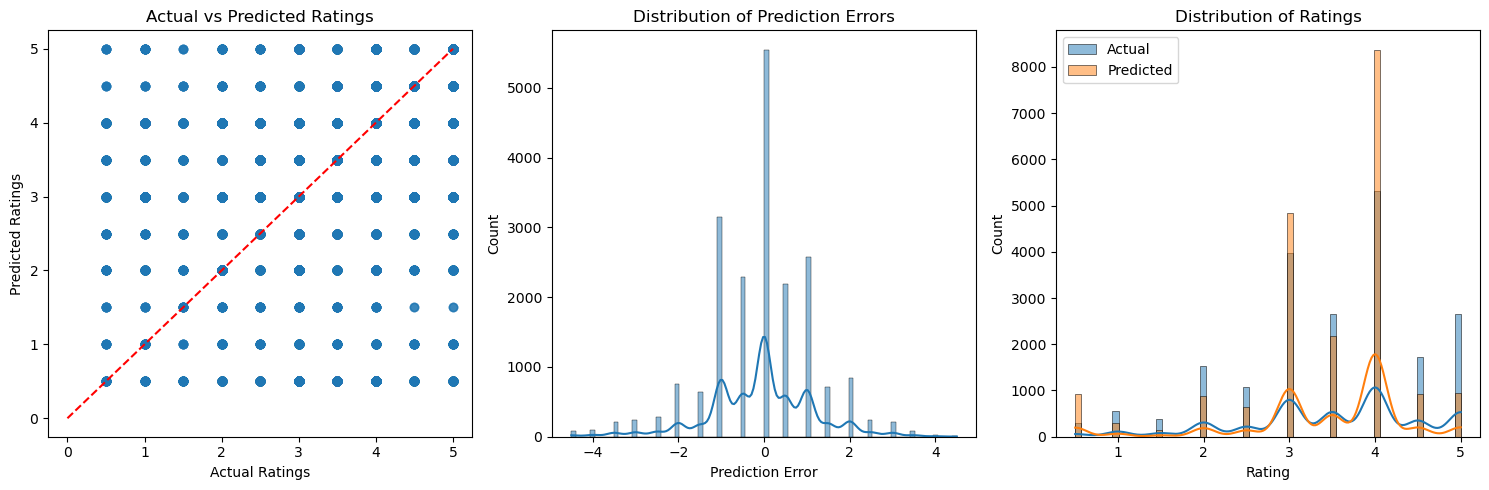


Universal Evaluation Metrics:
MSE: 1.5387
RMSE: 1.2404
MAE: 0.8812


In [27]:

test_df = pd.DataFrame(test_data, columns=["userId", "movieId"] + pca_columns + ["rating"])
spn_model = SPNRecommender(spn, pca_columns, test_df)

# 評估與繪圖
report = BaseRecommenderReporter()
results = report.evaluate_model(spn_model, test_df)
report.plot_all()
report.print_stats()
